In [14]:
import os
import csv
import struct
import chardet
import itertools
import numpy as np
import collections
import pandas as pd
from typing import *
from time import time
import seaborn as sns
from sklearn.svm import SVC
from inspect import signature
from skimage.feature import hog
from numpy import random as rnd
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplot
from sklearn.utils import shuffle
import matplotlib.font_manager as fm
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import make_scorer
from IPython.display import clear_output
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV

In [ ]:
!ls

# Data Reading

In [7]:
class ReadData():
    def __init__(self, year=2017):
        self.year = year
        self.infos = []  # all infos from input
        self.data_infos = []  # features from read() object
        self.selected_features = None  # selected features by user. set from self.get_features_index
        self.no_data = []  # datas with empty value
        self.required_info_index = []  # selected features' index
        self.no_data_count = collections.defaultdict(int)  # to count and show size of empty value
        self.X = []
        self.y = []
        
    def show_params(self):
        # shows parameters from read()
        sig = signature(self.read)
        params = []
        for param in sig.parameters.values():
            params.append(str(param.name)+'='+str(param.default))
        print(*params)
            
    def read(self, selected_features, DATASIZE=None, FBS_PIVOT=120, calculate_BMI=True, return_data=True, 
            count_empty_data=False, filter_dict=None):
        # selected_features = features to select from data, DATASIZE = set limit(size) of data
        # FBS_PIVOT = if 식전혈당(공복혈당) >= FBS_PIVOT then set diabetic
        # if calculate_BMI is True = append BMI and remove height, weight
        # return_data = whether return X,y or not, count_empty_data = counts data with empty value
        # filter_dict = filtering outliers with this dict
        
#         self.get_features_index(selected_features)
        
        print(f'Reading Year {self.year}')
        if not DATASIZE:
            DATASIZE = float('inf')
        if self.year == 2017:
            FILENAME = 'NHIS_OPEN_GJ_2017_100.csv'
        elif self.year == 2018:
            FILENAME = 'NHIS_OPEN_GJ_2018_100.csv'
        else:
            raise Exception('year should be 2017 or 2018. default=2017')
            
        
        with open(FILENAME, 'rb') as f:
            ENCODING = chardet.detect(f.readline())['encoding']
            
        f = open(FILENAME, 'r', encoding=ENCODING)
        rdr = csv.reader(f)
        
#         self.infos = list(rdr)[0]
#         self.infos = self.infos[0]
#         self.get_features_index(selected_features)
        required_info_index = []
        
#         required_info_index = self.required_info_index

        for n, col in enumerate(rdr):  # read and store data from csv
            try:
                required_data = [info for index, info in enumerate(col) if index in required_info_index]
            except:
                pass
            if n == 0:
                self.infos = col
#                 print(self.infos)
#                 self.infos.append(col)
#                 self.infos = self.infos[0]
                self.get_features_index(selected_features)
                required_info_index = self.required_info_index
                self.data_infos = [info for index, info in enumerate(col) if index in required_info_index]
#                 self.data_infos = self.data_infos[0]
                FBS_INDEX = self.infos.index('식전혈당(공복혈당)')
                if calculate_BMI:
                    if '신장(5Cm단위)' not in self.data_infos or '체중(5Kg단위)' not in self.data_infos:
                        calculate_BMI = False
                    else:
                        HEIGHT_INDEX, WEIGHT_INDEX = self.data_infos.index('신장(5Cm단위)'), self.data_infos.index('체중(5Kg단위)')
                        if WEIGHT_INDEX < HEIGHT_INDEX:
                            raise Exception('selected_features에서 신장을 체중보다 먼저 오도록 설정해주세요.')
            else:
                FBS = col[FBS_INDEX]
                if '' in required_data or FBS == '':
                    if count_empty_data:
                        l = [self.data_infos[i] for i, d in enumerate(required_data) if d == '']
                        for s in l: 
                            self.no_data_count[s] += 1
                        self.no_data.append(n)
                else:
                    self.X.append(required_data)
                    self.y.append(1) if int(FBS) >= FBS_PIVOT else self.y.append(0)
                    
            if n >= DATASIZE:
                break

        f.close()
        
        if filter_dict:
            self.filter_outliers(filter_dict)
        if calculate_BMI:
            self.calculate_BMI()
            del self.data_infos[HEIGHT_INDEX]
            del self.data_infos[WEIGHT_INDEX-1]
            
        self.X = np.array(self.X, dtype=np.float64)
        self.y = np.array(self.y)
        
        print(f"Reading Year {self.year}'s data done")
        print(f'Size of X = {len(self.X):,}, y = {len(self.y):,}')
        print(f'당뇨병 판별 공복혈당 기준 수치 : {FBS_PIVOT}')
        counts = np.unique(self.y, return_counts = True)[1]
        print(f'당뇨병 판별 환자 수 : {counts[1]:,}명, 비당뇨병 판별수 : {counts[0]:,}명\n')
        print(f'X has {self.X.shape[1]} features')
        if count_empty_data:
            print(f'Size of data with empty value = {len(self.no_data):,}')
        print(f'Selected Features and Sample Data: \n{self.data_infos}\n{self.X[0]}\n{self.X[1]}')
        if return_data:
            return [self.X, self.y]
        
    def calculate_BMI(self):
        # calculate and append BMI with height, weight and remove height, weight from data.
        try:
            HEIGHT_INDEX, WEIGHT_INDEX = self.data_infos.index('신장(5Cm단위)'), self.data_infos.index('체중(5Kg단위)')
        except:
            raise Exception('신장 혹은 체중이 데이터에 없어서 BMI를 계산할 수 없습니다.')
        if WEIGHT_INDEX < HEIGHT_INDEX:
            raise Exception('selected_features 순서에서 신장을 체중보다 먼저 오도록 설정해주세요.')
            
        self.data_infos.append('BMI')
        
        for i in range(len(self.X)):
            height, weight = int(self.X[i].pop(HEIGHT_INDEX)), int(self.X[i].pop(WEIGHT_INDEX-1))
            BMI = round(weight / (height * height / 10000), 2)
            self.X[i].append(BMI)
    
    def get_features_index(self, selected_features):
        # set selected features at object.
        for feature in selected_features:
            if feature not in self.infos:
                raise Exception(f"'{feature}'는 데이터에 없습니다.")
            self.required_info_index.append(self.infos.index(feature))
        self.required_info_index.sort()
        self.selected_features = selected_features
            
    def show_outliers(self, feature:str, pivot:int, not_diabetes_only=True):
        # shows outlier's value from specific feature and pivot.
        # if not_diabetes_only is True = shows outliers who is not diabetic.
        # if not_diabetes_only is False = shows all outliers.
        OUT_INDEX = self.data_infos.index(feature)
        outliers = []
        if not_diabetes_only:
            fbs_index = self.data_infos.index('식전혈당(공복혈당)')
            bmi_index = self.data_infos.index('BMI')
            for i in range(len(self.X)):
                if self.y[i] != 1 and (self.X[i][OUT_INDEX] > pivot or self.X[i][OUT_INDEX] <= 0):
                    outliers.append(i)
        else:
            for i in range(len(self.X)):
                if self.X[i][OUT_INDEX] >= pivot or self.X[i][OUT_INDEX] <= 0:
                    outliers.append(i)
                    
        max_outlier = max([self.X[i][OUT_INDEX] for i in outliers])
                          
        if not_diabetes_only:
            print(f'{feature}에서 기준치 {pivot} 이상이며, 당뇨가 아닌 사람들의 값입니다. '+
                  f'(총 {len(outliers)}명, 비율: %.2f%%, 최댓값: {max_outlier})\n'%(len(outliers) * 100 / len(self.X)))

            print('{:>6} {:>16} {:>20} {:>10}'.format('INDEX', feature, '식전혈당(공복혈당)', 'BMI'))
            for i in outliers if len(outliers) < 20 else outliers[:20]:
                print('{:6} {:>22.0f} {:>28.0f} {:>10}'.format(i, self.X[i][OUT_INDEX], 
                                                               self.X[i][fbs_index], self.X[i][bmi_index]))
        else:
            print(f'{feature}에서 {pivot}보다 큰 값들입니다.' +
                  f'(총 {len(outliers)}명, 비율: %.2f%%, 최댓값: {max_outlier})\n'%(len(outliers) * 100 / len(self.X)))
            for i in outliers if len(outliers) < 20 else outliers[:20]:
                print(self.X[i][OUT_INDEX])

    def sizeof_outliers(self, filter_dict):
        # only shows size of outliers who will be filtered by filter_dict.
        size = len(self.X)
        X_isnumpy = isinstance(self.X, np.ndarray)
        if X_isnumpy:
            filter_X = self.X[:].tolist()
            filter_y = self.y[:].tolist()
        else:
            filter_X = self.X[:]
            filter_y = self.y[:]
        filter_index = [self.data_infos.index(key) for key in list(filter_dict.keys())]
        filter_pivot = list(filter_dict.values())
        for f in range(len(filter_index)):
            max_pivot, min_pivot = filter_pivot[f]
            f_index = filter_index[f]
            max_out, min_out = 0, 0
            for i in range(len(filter_X)):
                if float(filter_X[i][f_index]) >= max_pivot:
                    max_out += 1
                elif float(filter_X[i][f_index]) <= min_pivot:
                    min_out += 1
            
            print(f'Max Pivot:{max_pivot:>5}, Min Pivot:{min_pivot:>5}, '+
                  f'Max Outs: {max_out:>5,}, Min Outs: {min_out:>5,}, '+
                  f'{(max_out+min_out)*100/size:>3.2f}% at {self.data_infos[f_index]:<20}')
            
    def filter_outliers(self, filter_dict):
        # excute filtering outliers by filter_dict. filter_dict[feature] = [MAX PIVOT, MIN PIVOT]
        print('Filtering outliers')
        original_size = len(self.X)
        X_isnumpy = isinstance(self.X, np.ndarray)
        if X_isnumpy:
            filter_X = self.X[:].tolist()
            filter_y = self.y[:].tolist()
        else:
            filter_X = self.X[:]
            filter_y = self.y[:]
            
        filter_index = [self.data_infos.index(key) for key in list(filter_dict.keys())]
        filter_pivot = list(filter_dict.values())
        
        for f in range(len(filter_index)):
            max_pivot, min_pivot = filter_pivot[f]
            correction = 0
            f_index = filter_index[f]
            for i in range(len(filter_X)):
                try:
                    if float(filter_X[i][f_index]) >= max_pivot or float(filter_X[i][f_index]) <= min_pivot:
                        del filter_X[i - correction]
                        del filter_y[i - correction]
                        correction += 1
                except:
                    print(f'Filtered {correction:>5,} by {self.data_infos[f_index]}')
                    break
        if X_isnumpy:
            self.X = np.array(filter_X, dtype=np.float64)
            self.y = np.array(filter_y)
        else:
            self.X, self.y = filter_X, filter_y
        print(f'Filtered {original_size - len(self.X):,}. Filterd X size : {len(self.X):,}. '+
              f'({(original_size - len(self.X))*100/original_size:.2f}%)\n')
        
    def get_specific_data(self, features):
        index = [self.data_infos.index(feature) for feature in features]
        return np.array(self.X[0:, index])

# Read Data

In [8]:
data2017 = ReadData(2017)
data2017.show_params()

selected_features=<class 'inspect._empty'> DATASIZE=None FBS_PIVOT=120 calculate_BMI=True return_data=True count_empty_data=False filter_dict=None


In [9]:
filter_dict = {  # 'feature': [MAX Pivot, MIN Pivot] to filter outlier
    '총콜레스테롤': [500, 10], 
    '트리글리세라이드': [700, 10], 
    'LDL콜레스테롤': [500, 10], 
    '허리둘레': [150, 30], 
    '감마지티피': [300, 5], 
    '혈색소': [18.5, 3], 
    '(혈청지오티)ALT': [200, 5], 
    '(혈청지오티)AST': [200, 5], 
    '신장(5Cm단위)': [200, 140], 
    '체중(5Kg단위)': [140, 30], 
    '식전혈당(공복혈당)': [300, 30]
}
selected_features = list(filter_dict.keys())
data2017 = ReadData(2017)
# selected_features = Features to read, DATASIZE = Data size limit, FBS_PIVOT = 당노병 판단 기준 혈당
# calculate_BMI = 체중, 키를 BMI지수로 환산, return_data = return X,y for variable
# count_empty_data = count data with empty value
data2017.read(selected_features, FBS_PIVOT=140, filter_dict=filter_dict, return_data=False)

Reading Year 2017
Filtering outliers
Filtered    62 by 총콜레스테롤
Filtered 3,671 by 트리글리세라이드
Filtered   349 by LDL콜레스테롤
Filtered    61 by 허리둘레
Filtered 6,882 by 감마지티피
Filtered 1,134 by 혈색소
Filtered 3,895 by (혈청지오티)ALT
Filtered 1,121 by (혈청지오티)AST
Filtered 10,365 by 신장(5Cm단위)
Filtered   175 by 체중(5Kg단위)
Filtered 1,507 by 식전혈당(공복혈당)
Filtered 29,222. Filterd X size : 967,581. (2.93%)

Reading Year 2017's data done
Size of X = 967,581, y = 967,581
당뇨병 판별 공복혈당 기준 수치 : 140
당뇨병 판별 환자 수 : 44,698명, 비당뇨병 판별수 : 922,883명

X has 10 features
Selected Features and Sample Data: 
['허리둘레', '식전혈당(공복혈당)', '총콜레스테롤', '트리글리세라이드', 'LDL콜레스테롤', '혈색소', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', 'BMI']
[ 90.    99.   193.    92.   126.    17.1   21.    35.    40.    25.95]
[ 89.   106.   228.   121.   148.    15.8   20.    36.    27.    24.69]


In [ ]:
data2018 = ReadData(2018)
data2018.read(selected_features, FBS_PIVOT=140, filter_dict=filter_dict, return_data=False)

# Scaling

In [10]:
# scaler = MinMaxScaler()
# X = scaler.fit_transform(X[:])
def scale_robust(X_train, X_test):
    robustScaler = RobustScaler()
    robustScaler.fit(X_train[:])
    X_train = robustScaler.transform(X_train[:])
    X_test = robustScaler.transform(X_test[:])
#     print(f'Sample Scaled Data : {X_train[0]}')
    return [X_train[:], X_test[:]]

# Split Training, Test Set
(If required)

In [11]:
def split_set(X, y):
    # X_train, X_test, y_train, y_test
    return train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Logistic Regression

In [12]:
class DiabetesModelingLR():
    def __init__(self):
        self.X = None
        self.y = None
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.clf = None
        self.training_size = None
        self.testing_size = None
        self.SCALE = True
    def make_model(self, X=None, y=None, X_train=None, y_train=None, 
                   X_test=None, y_test=None, CV=False):
        if X is not None:
            self.X, self.y = X, y
            self.X_train, self.X_test, self.y_train, self.y_test = split_set(X, y)
        else:
            self.X_train, self.y_train = X_train, y_train
            self.X_test, self.y_test = X_test, y_test
            
        if self.X_train.shape[1] != self.X_test.shape[1]:
            raise Exception('Training Set과 Test Set의 Feature가 다릅니다.')
        if self.SCALE:
            self.X_train, self.X_test = scale_robust(self.X_train, self.X_test)
            
        self.training_size = len(self.X_train)
        self.testing_size = len(self.X_test)
        
        if CV:
            self.clf = LogisticRegressionCV(cv=5, solver='saga', penalty='l2')
        else:
            self.clf = LogisticRegression(C=1e-2, solver='saga', penalty='l2')
            
        self.clf.fit(self.X_train, self.y_train)
        
    def get_result(self):
        clf = self.clf
        accuracy = round(accuracy_score(self.y_test, clf.predict(self.X_test)), 5)
        y_predict = clf.predict(self.X_test)
        clf_report = classification_report(self.y_test, y_predict, target_names=['건강','당뇨'])
        return [accuracy, clf_report]
    
    def get_f1_score(self):
        clf = self.clf
        f1score = f1_score(self.y_test, clf.predict(self.X_test))
        return f1score
    
    def show_result(self):
        clf = self.clf
        print(f'Training size : {self.training_size:,} Testing Size : {self.testing_size:,}')
        counts = np.unique(self.y_test, return_counts = True)[1]
        print(f'Test Set 당뇨병 인원수 : {counts[1]:,}명, 비당뇨병 인원수 : {counts[0]:,}명\n')
        print(f'Accuracy score: {round(accuracy_score(self.y_test, clf.predict(self.X_test)), 5)}',' '*5,
              f'F1 Score: {round(f1_score(self.y_test, clf.predict(self.X_test)), 5)}\n')

        y_predict = clf.predict(self.X_test)
        print(classification_report(self.y_test, y_predict, target_names=['건강','당뇨']))
        cm = confusion_matrix(self.y_test, y_predict)
        print('Confusion Matrix\n', cm)

In [13]:
testmodel = DiabetesModelingLR()
testmodel.make_model(X=data2017.X, y=data2017.y, CV=False)
testmodel.show_result()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training size : 774,064 Testing Size : 193,517
Test Set 당뇨병 인원수 : 8,940명, 비당뇨병 인원수 : 184,577명

Accuracy score: 0.99361       F1 Score: 0.92568

              precision    recall  f1-score   support

          건강       0.99      1.00      1.00    184577
          당뇨       1.00      0.86      0.93      8940

    accuracy                           0.99    193517
   macro avg       1.00      0.93      0.96    193517
weighted avg       0.99      0.99      0.99    193517

Confusion Matrix
 [[184576      1]
 [  1236   7704]]


# Visualization

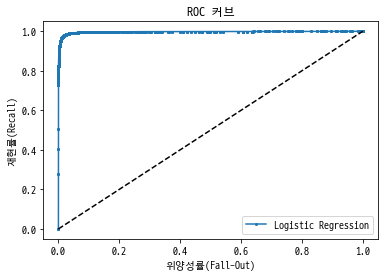

In [16]:
fpr1, tpr1, thresholds1 = roc_curve(data2017.y, testmodel.clf.decision_function(data2017.X))

plt.plot(fpr1, tpr1, 'o-', ms=2, label="Logistic Regression")
plt.legend()
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.xlabel('위양성률(Fall-Out)')
plt.ylabel('재현률(Recall)')
plt.title('ROC 커브')
plt.show()

In [ ]:
cvmodel = DiabetesModelingLR()
cvmodel.make_model(X=data2017.X, y=data2017.y, CV=True)
# data size 0.9M, time 29m

In [ ]:
no_cv_model = DiabetesModelingLR()
no_cv_model.make_model(X=data2017.X, y=data2017.y, CV=False)

In [ ]:
cvmodel.show_result()

In [ ]:
print(no_cv_model.get_result()[1])

In [ ]:
no_cv_model.show_result()

In [ ]:
# training data = year 2017, test data = year 2018
model = DiabetesModelingLR()
model.make_model(X_train=data2017.X, y_train=data2017.y, X_test=data2018.X, y_test=data2018.y)

In [ ]:
model.show_result()

# Grid Search by Features
### (not hyper-parameters)

In [ ]:
gridtest = ReadData(2017)
gridtest.read(list(filter_dict.keys()), return_data=False, filter_dict=filter_dict)

In [ ]:
grid_features = ['트리글리세라이드', '총콜레스테롤', 'LDL콜레스테롤', '허리둘레', 
                 '감마지티피', '혈색소', '(혈청지오티)ALT', '(혈청지오티)AST']
combs, feature_combinations = [], []
for i in range(1, len(grid_features)):
    t = []
    t.append(list(itertools.combinations(grid_features, i)))
    for j in range(len(t)):
        combs.append(t[j])
for f in combs:
    for ff in f:
        feature_combinations.append(list(ff)+['BMI'])

In [ ]:
results = []
for features in feature_combinations:
    gridmodel = DiabetesModelingLR()
    gridmodel.make_model(X=gridtest.get_specific_data(features), y=gridtest.y)
    results.append(gridmodel.get_f1_score())
clear_output()

# Show f1_scores from grid search

In [ ]:
max_i, max_f1 = 0,0
for i, f1 in enumerate(results):
    if f1 >= max_f1:
        max_i, max_f1 = i, f1
    print(f'{f1:5>.4} = {feature_combinations[i]}')

In [ ]:
print(f'Highest f1 score is {max_f1:.4}, features : {feature_combinations[max_i]}')

In [ ]:
test.show_outliers(feature='체중(5Kg단위)', pivot=100, not_diabetes_only=False)

In [ ]:
# show_outliers(self, feature, pivot, not_diabetes_only=True)
look.show_outliers(feature='총콜레스테롤', pivot=500, not_diabetes_only=False)

In [ ]:
look.show_outliers(feature='식전혈당(공복혈당)', pivot=600, not_diabetes_only=False)

In [ ]:
look.show_outliers(feature='트리글리세라이드', pivot=700, not_diabetes_only=False)

In [ ]:
look.show_outliers(feature='LDL콜레스테롤', pivot=300, not_diabetes_only=False)

In [ ]:
look.show_outliers(feature='허리둘레', pivot=150, not_diabetes_only=False)

In [ ]:
look.show_outliers(feature='감마지티피', pivot=300, not_diabetes_only=False)

In [ ]:
look.show_outliers(feature='혈색소', pivot=18, not_diabetes_only=False)

In [ ]:
look.show_outliers(feature='(혈청지오티)ALT', pivot=200, not_diabetes_only=True)

In [ ]:
look.show_outliers(feature='(혈청지오티)AST', pivot=200, not_diabetes_only=False)

# Support Vector Machine

In [ ]:
class DiabetesModelingSVM():
    def __init__(self, X=None, y=None):
        self.X = X
        self.y = y
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.clf = None
        self.training_size = None
        self.testing_size = None
        self.CROSSVAL=False
        self.SPLIT_DATA = True
        self.RESET_FBS = False
    def SVM(self):
        X, y = self.X, self.y
        if self.RESET_FBS:
            FBS = 120
            year = 2017
            X, y = reset_fbs(fbs=FBS, year=year)
        if self.SPLIT_DATA:
            X_train, X_test, y_train, y_test = split_set(X, y)
            self.X_train, self.X_test, self.y_train, self.y_test = [
                X_train, X_test, y_train, y_test]
        if X_train.shape[1] != X_test.shape[1]:
            raise Exception('Training Set과 Test Set의 Feature가 다릅니다.')

        self.training_size = len(X_train)
        self.testing_size = len(X_test)
        self.clf = SVC(random_state=42, decision_function_shape='ovo', kernel='rbf',
                      gamma=0.1, C=0.0001)
#         self.clf = SVC(C=1e-2, multi_class='ovr',
#                                  penalty='l2', solver='liblinear', tol=0.1)
#         if self.CROSSVAL:
#             self.clf = LogisticRegressionCV(C=1, multi_class='ovr', cv=5,
#                                  penalty='l2', solver='saga', tol=0.1)

        self.clf.fit(X_train, y_train)
        clear_output()
        y_predict = self.clf.predict(X_test)
        
    def show_result(self):
        clf = self.clf
        print('Training size : %d Testing Size : %d' %(self.training_size, self.testing_size))
        counts = np.unique(self.y, return_counts = True)[1]
        print(f'당뇨병 판별 환자 수 : {counts[1]}, 비당뇨병 판별수 : {counts[0]}\n')
        print(f'Accuracy score: {round(accuracy_score(self.y_test, clf.predict(self.X_test)), 5)}\n')

        y_predict = clf.predict(self.X_test)
        print(classification_report(self.y_test, y_predict, target_names=['건강','당뇨']))
        cm = confusion_matrix(self.y_test, y_predict)
        print('Confusion Matrix\n', cm)

## Data Resize Required

In [ ]:
model2017SVM = DiabetesModelingSVM(X,y)
model2017SVM.SVM()
# 1h 22m

In [ ]:
model2017SVM.show_result()
# 52m

# Grid Search

In [ ]:
class GridSearch():
    def __init__(self, grid_parameters, model=LogisticRegression, X=X, y=y):
        self.model = model
        self.grid_parameters = grid_parameters
        self.X = X
        self.y = y
        self.clf = None
        self.best_parameters = None
        self.best_estimator = None
        
    def make_estimator(self, model, X=None, y=None, default_parameters=None,
                       grid_parameters=None, cross_validation:int=5):
        clf = model(**default_parameters)
        estimator = GridSearchCV(clf, grid_parameters, cv=cross_validation, n_jobs=-1)
        estimator.fit(X,y)
        
        return estimator
    
    def grid_search(self):
        X_train, X_test, y_train, y_test = split_set(self.X, self.y)
        self.clf = self.make_estimator(X=X_train, y=y_train, model=self.model,
                                       default_parameters=dict(solver='lbfgs'),
                                       grid_parameters=self.grid_parameters)
        self.best_parameters = clf.best_params_
        self.best_estimator = clf.best_estimator_

        # get best accuracy on training set
        print('Input Grid Parameters')
        print(self.grid_parameters)
        
        print('Accuracy on training set')
        print(round(self.clf.best_score_, 5))

        print('Accuracy on test set')
        print(round(self.best_estimator.score(X_test, y_test), 5))

        print(f'Best Parameters : {self.best_parameters}')

In [ ]:
grid_parameters = {
    'C': [1e-1, 1, 1000]
#     'penalty': ['l1', 'l2'],
#     'batch_size':[1, 10, 60, 100, 600]
#     'epochs':[5, 10, 25, 50, 200]
#     'C': [1e-4, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1000], # 1000 means no regularization
#     'solver': ['saga']
}
grid_search_2017_LR = GridSearch(grid_parameters=grid_parameters, model=LogisticRegression)
grid_search_2017_LR.grid_search()

In [ ]:
def scale(train_data, scatter_show_YN=False, kdeplot_show_YN=False):    
    from sklearn.preprocessing import MinMaxScaler
    minMaxScaler = MinMaxScaler()
    %time print(minMaxScaler.fit(train_data))
    train_data_minMaxScaled =  pd.DataFrame(minMaxScaler.transform(train_data), columns=['x1', 'x2'])

    from sklearn.preprocessing import MaxAbsScaler
    maxAbsScaler = MaxAbsScaler()
    %time print(maxAbsScaler.fit(train_data))
    train_data_maxAbsScaled = pd.DataFrame(maxAbsScaler.transform(train_data), columns=['x1', 'x2'])

    from sklearn.preprocessing import StandardScaler
    standardScaler = StandardScaler()
    %time print(standardScaler.fit(train_data))
    train_data_standardScaled = pd.DataFrame(standardScaler.transform(train_data), columns=['x1', 'x2'])

    from sklearn.preprocessing import RobustScaler
    robustScaler = RobustScaler()
    %time print(robustScaler.fit(train_data))
    train_data_robustScaled = pd.DataFrame(robustScaler.transform(train_data), columns=['x1', 'x2'])

    if(kdeplot_show_YN is True):
        kdeplot_show(train_data, train_data_minMaxScaled, train_data_maxAbsScaled, train_data_standardScaled, train_data_robustScaled)    
    
    if(scatter_show_YN is True):
        scatter_show(train_data, train_data_minMaxScaled, train_data_maxAbsScaled, train_data_standardScaled, train_data_robustScaled)

In [ ]:
def scatter_show(train_data, train_data_minMaxScaled, train_data_maxAbsScaled, train_data_standardScaled, train_data_robustScaled):    
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(19,4))
    scatter_sub_draw(sub_ax=ax[0], x=train_data['x1'], y=train_data['x2'],
                                  title='train_data', size=2, color1='k', color2='c')
    scatter_sub_draw(sub_ax=ax[1], x=train_data_minMaxScaled['x1'], y=train_data_minMaxScaled['x2'],
                                  title='train_data_minMaxScaled', size=2, color1='g', color2='c')
    scatter_sub_draw(sub_ax=ax[2], x=train_data_maxAbsScaled['x1'], y=train_data_maxAbsScaled['x2'],
                                  title='train_data_maxAbsScaled', size=2, color1='g', color2='c')
    scatter_sub_draw(sub_ax=ax[3], x=train_data_standardScaled['x1'], y=train_data_standardScaled['x2'],
                                  title='train_data_standardScaled', size=2, color1='g', color2='c')
    scatter_sub_draw(sub_ax=ax[4], x=train_data_robustScaled['x1'], y=train_data_robustScaled['x2'],
                                  title='train_data_robustScaled', size=2, color1='g', color2='c')
    
def scatter_sub_draw(sub_ax, x, y, title, size, color1, color2):
    sub_ax.scatter(x, y, s=size, color=color1)
    sub_ax.grid(True)
    sub_ax.set_title(title)
    sub_ax.set_xlabel(x.name)
    sub_ax.set_ylabel(y.name)
    # median  line draw
    sub_ax.axvline(x=x.median(), color=color2, linestyle='--', linewidth=0.5)
    sub_ax.axhline(y=y.median(), color=color2, linestyle='--', linewidth=0.5)

In [ ]:
def kdeplot_show(train_data, train_data_minMaxScaled, train_data_maxAbsScaled, train_data_standardScaled, train_data_robustScaled):
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(19,4))
    kdeplot_sub_draw(sub_ax=ax[0], x=train_data['x1'], y=train_data['x2'], 
                                  title='train_data', size=1, color1='r', color2='b')
    kdeplot_sub_draw(sub_ax=ax[1], x=train_data_minMaxScaled['x1'], y=train_data_minMaxScaled['x2'], 
                                  title='train_data_minMaxScaled', size=1, color1='r', color2='b')
    kdeplot_sub_draw(sub_ax=ax[2], x=train_data_maxAbsScaled['x1'], y=train_data_maxAbsScaled['x2'], 
                                  title='train_data_maxAbsScaled', size=1, color1='r', color2='b')
    kdeplot_sub_draw(sub_ax=ax[3], x=train_data_standardScaled['x1'], y=train_data_standardScaled['x2'], 
                                  title='train_data_standardScaled', size=1, color1='r', color2='b')
    kdeplot_sub_draw(sub_ax=ax[4], x=train_data_robustScaled['x1'], y=train_data_robustScaled['x2'], 
                                  title='train_data_robustScaled', size=1, color1='r', color2='b')
    
def kdeplot_sub_draw(sub_ax, x, y, title, size, color1, color2):
    # sns.kdeplot: Fit and plot a univariate or bivariate kernel density estimate
    import seaborn as sns
    sub_ax.grid(True)
    sub_ax.set_title(title)
    sns.kdeplot(x, ax=sub_ax, shade=True, color=color1)
    sns.kdeplot(y, ax=sub_ax, shade=True, color=color2)
    # median  line draw
    sub_ax.axvline(x=x.median(), color=color1, linestyle='--', linewidth=0.5)
    sub_ax.axvline(x=y.median(), color=color2, linestyle='--', linewidth=0.5)

In [ ]:
train_data = pd.DataFrame({
    'x1': X[1],
    'x2': X[2]
})

In [ ]:
scale(train_data, scatter_show_YN=True, kdeplot_show_YN=True)